<a href="https://colab.research.google.com/github/Mashaell22/repot5/blob/main/Copy_of_Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 33.5MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [127]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, GRU


In [25]:
# Load
df  = pd.read_csv('Traffic Data.csv')

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

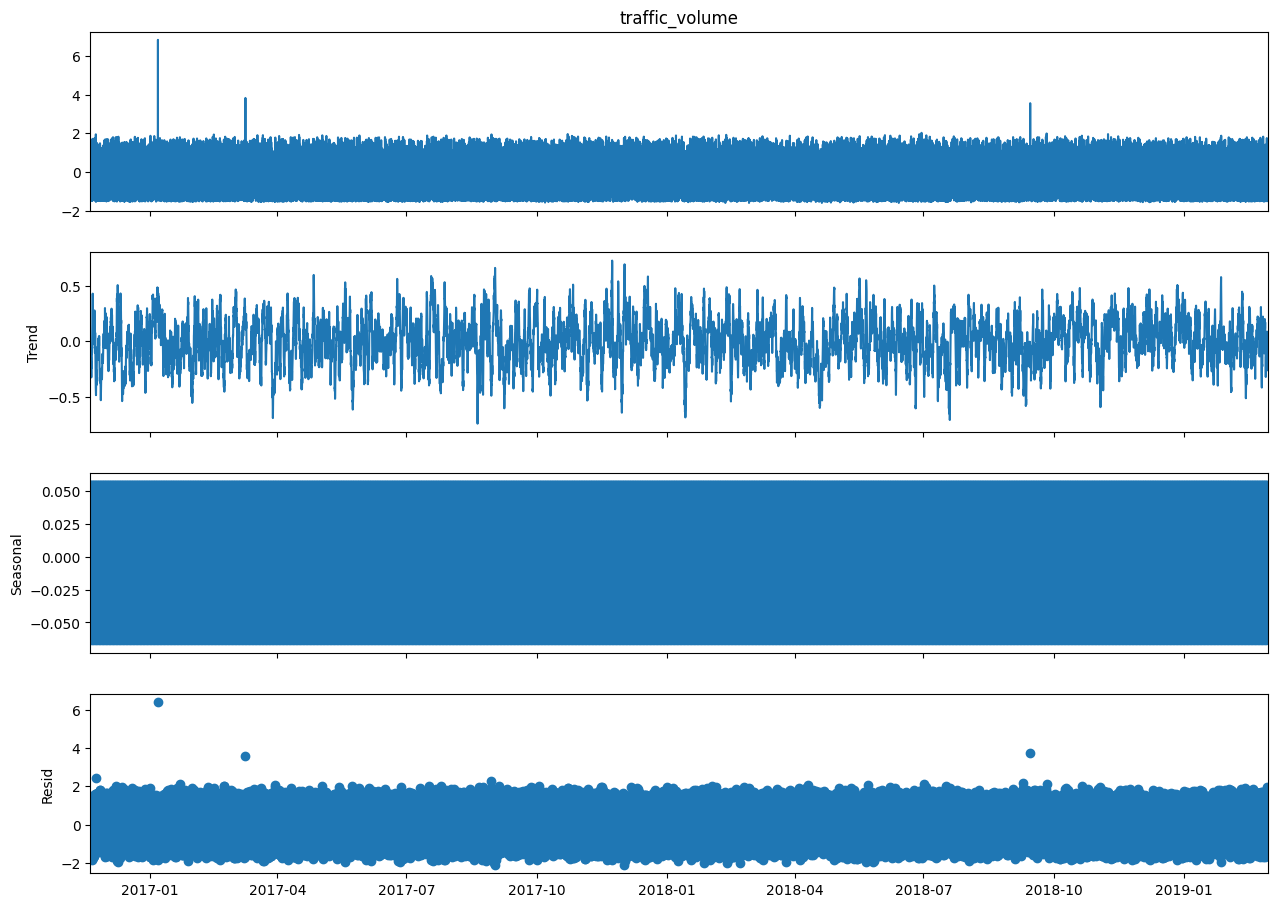

In [147]:
#  Seasonal tred seasonality residuals
decomposition = seasonal_decompose(traffic_data['traffic_volume'], model='additive', period=24)  #SSasonality
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

In [26]:
# info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [28]:
print(df.columns)

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description'],
      dtype='object')


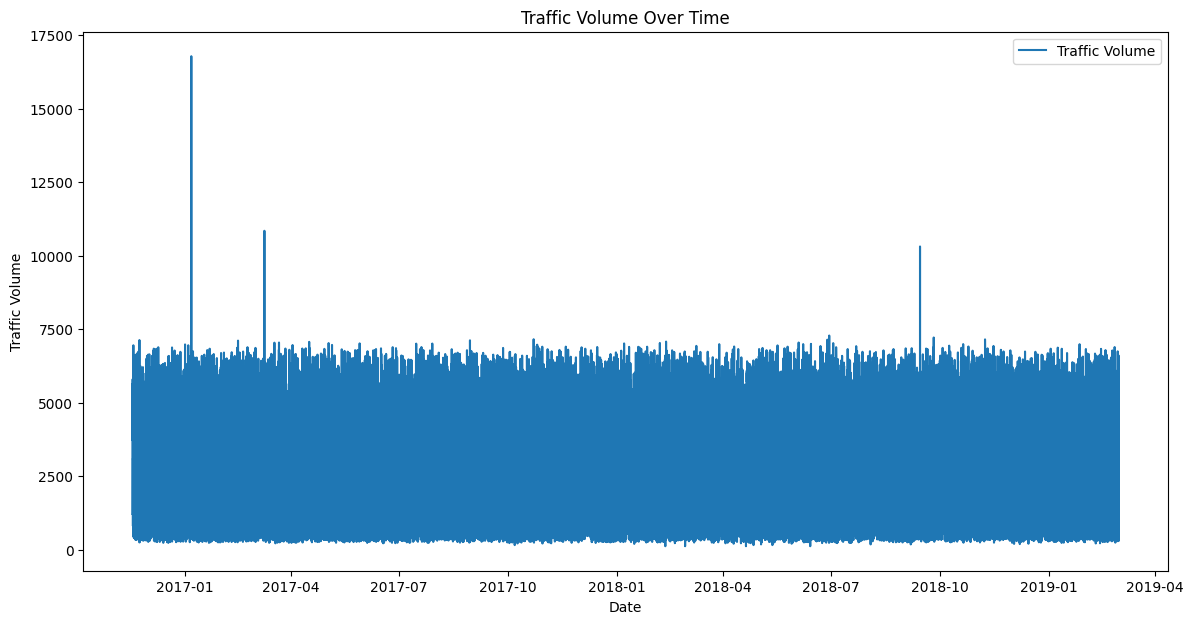

In [10]:
# Plot the time series data
plt.figure(figsize=(14, 7))
plt.plot(traffic_data['traffic_volume'], label='Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Over Time')
plt.legend()
plt.show()

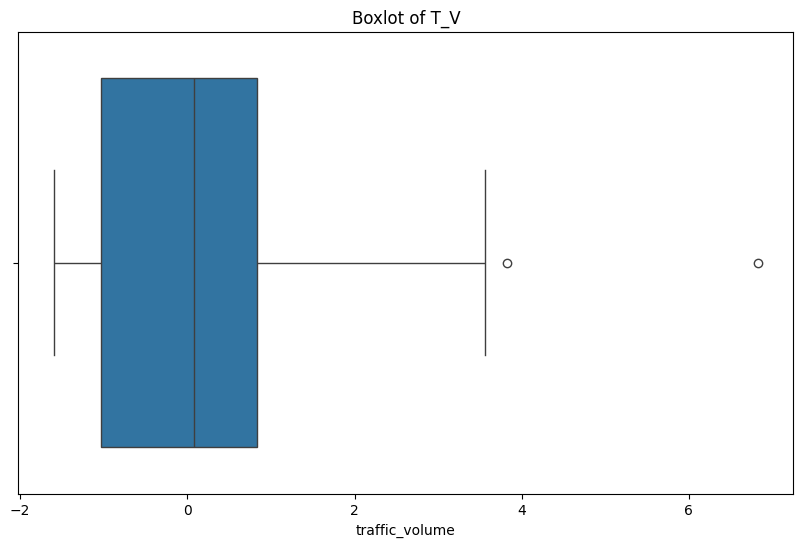

In [150]:
#  boxplot identify outliers in traffic volume
plt.figure(figsize=(10, 6))
sns.boxplot(x=traffic_data['traffic_volume'])
plt.title('Boxlot of T_V')
plt.show()

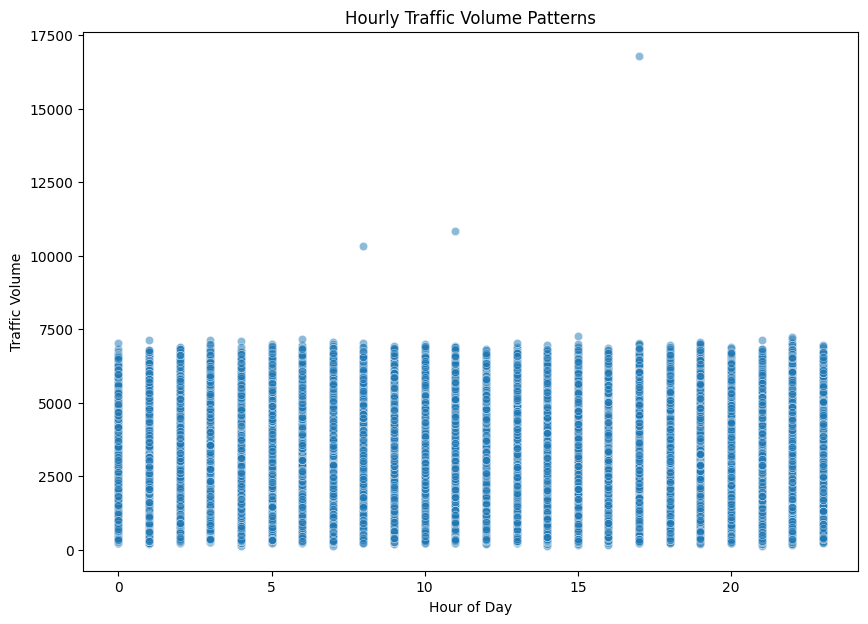

In [18]:
# Scatter plot to analyze hourly patterns in traffic volume
plt.figure(figsize=(10, 7))
sns.scatterplot(x=traffic_data.index.hour, y=traffic_data['traffic_volume'], alpha=0.5)
plt.title('Hourly Traffic Volume Patterns')
plt.xlabel('Hour of Day')
plt.ylabel('Traffic Volume')
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [75]:
# Check missing values
missing_values = traffic_data.isnull().sum()
print("Missing values before filling:")
print(missing_values)

Missing values before filling:
traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
dtype: int64


In [77]:
# Fill missing if
traffic_data.fillna(method='ffill', inplace=True)

<ipython-input-77-d8eb8dbd640a>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  traffic_data.fillna(method='ffill', inplace=True)


In [78]:
# Verify that no missn valuesremain
missing_values_after = traffic_data.isnull().sum()
print("Missing values after filling:")
print(missing_values_after)


Missing values after filling:
traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
dtype: int64


In [88]:
# Add lag features (e.g., traffic volume from the previous hour)
traffic_data['lag_1'] = traffic_data['traffic_volume'].shift(1)
traffic_data['lag_2'] = traffic_data['traffic_volume'].shift(2)

In [90]:
# rolling average of the past 24 h
traffic_data['rolling_mean_24h'] = traffic_data['traffic_volume'].rolling(window=24).mean()

In [91]:
#sorted correctly
traffic_data = traffic_data.sort_index()

In [92]:
# Drop any rows with missing v created by shiftingrolling
traffic_data.dropna(inplace=True)

In [93]:
# Standardize the fet
scaler = StandardScaler()
traffic_data[['traffic_volume', 'lag_1', 'lag_2', 'rolling_mean_24h']] = scaler.fit_transform(
    traffic_data[['traffic_volume', 'lag_1', 'lag_2', 'rolling_mean_24h']]
)

In [94]:
# Display after preprocessing
print("Data after preprocessing:")
print(traffic_data.head())

Data after preprocessing:
                     traffic_volume    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                                   
2016-11-18 23:00:00       -1.440441  291.44      0.0      0.0           1   
2016-11-19 00:00:00        1.226264  294.22      0.0      0.0           1   
2016-11-19 01:00:00        1.074546  265.55      0.0      0.0           1   
2016-11-19 02:00:00       -1.184542  291.15      0.0      0.0          90   
2016-11-19 03:00:00       -0.601943  266.72      0.0      0.0          90   

                     weather_main               weather_description     lag_1  \
date_time                                                                       
2016-11-18 23:00:00         Clear                      sky is clear  0.806012   
2016-11-19 00:00:00  Thunderstorm  proximity thunderstorm with rain -1.440442   
2016-11-19 01:00:00          Mist                              mist  1.226273   
2016-11-19 02:00:00          

In [29]:
df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [32]:
df.fillna(method='ffill', inplace=True)

<ipython-input-32-e9443599d05e>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [95]:
#create a new column `prev_traffic_volume`
traffic_data['prev_traffic_volume'] = traffic_data['traffic_volume'].shift(24)  # Shift by 24 to get the previous days traffic v


In [97]:
#Calc difference between the current and previus t_v
traffic_data['traffic_volume_diff'] = traffic_data['traffic_volume'].diff()

In [98]:
# Extract
traffic_data['day_of_week'] = traffic_data.index.dayofweek  # Day of the week 0 = Monday, 6 = Sunday
traffic_data['month'] = traffic_data.index.month  # Month of the year 1 = January, 12 = December
traffic_data['day_of_year'] = traffic_data.index.dayofyear  # Day of the year 1 to 365 or 366

In [99]:
# Drop any rows with missing values  by shift
traffic_data.dropna(inplace=True)

In [100]:
# Display after feature en
print(traffic_data.head())

                     traffic_volume    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                                   
2016-11-19 23:00:00        0.863152  278.01      0.0      0.0          40   
2016-11-20 00:00:00       -0.071434  270.75      0.0      0.0          90   
2016-11-20 01:00:00        0.800441  275.58      0.0      0.0          75   
2016-11-20 02:00:00       -0.974665  278.34      0.0      0.0           1   
2016-11-20 03:00:00        0.723571  299.62      0.0      0.0           1   

                    weather_main weather_description     lag_1     lag_2  \
date_time                                                                  
2016-11-19 23:00:00       Clouds    scattered clouds  1.681936 -0.285327   
2016-11-20 00:00:00         Snow          light snow  0.863159  1.682018   
2016-11-20 01:00:00       Clouds       broken clouds -0.071430  0.863218   
2016-11-20 02:00:00        Clear        sky is clear  0.800449 -0.071397   
2016

In [35]:
#df.head ()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 00:00:00,None,291.15,0.0,0.0,90,Mist,mist
2016-11-18 01:00:00,mist,286.01,0.0,0.0,1,Clear,sky is clear
2016-11-18 02:00:00,sky is clear,293.69,0.0,0.0,75,Clouds,broken clouds
2016-11-18 03:00:00,broken clouds,262.35,0.0,0.0,1,Clear,sky is clear
2016-11-18 04:00:00,sky is clear,267.08,0.0,0.0,5,Clear,sky is clear


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [101]:
#80% training, 20% testing
train_size = int(len(traffic_data) * 0.8)

In [102]:

train_data = traffic_data.iloc[:train_size]
test_data = traffic_data.iloc[train_size:]

In [103]:
# Display the sizes
print(f"Training data size: {len(train_data)} rows")
print(f"Testing data size: {len(test_data)} rows")

Training data size: 15962 rows
Testing data size: 3991 rows


In [104]:

print("Training data sample:")
print(train_data.head())

Training data sample:
                     traffic_volume    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                                   
2016-11-19 23:00:00        0.863152  278.01      0.0      0.0          40   
2016-11-20 00:00:00       -0.071434  270.75      0.0      0.0          90   
2016-11-20 01:00:00        0.800441  275.58      0.0      0.0          75   
2016-11-20 02:00:00       -0.974665  278.34      0.0      0.0           1   
2016-11-20 03:00:00        0.723571  299.62      0.0      0.0           1   

                    weather_main weather_description     lag_1     lag_2  \
date_time                                                                  
2016-11-19 23:00:00       Clouds    scattered clouds  1.681936 -0.285327   
2016-11-20 00:00:00         Snow          light snow  0.863159  1.682018   
2016-11-20 01:00:00       Clouds       broken clouds -0.071430  0.863218   
2016-11-20 02:00:00        Clear        sky is clear  0.80

In [105]:
print("\nTesting data sample:")
print(test_data.head())



Testing data sample:
                     traffic_volume    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                                   
2018-09-16 01:00:00        0.101019  293.09      0.0      0.0          40   
2018-09-16 02:00:00        0.286116  288.86      0.0      0.0          90   
2018-09-16 03:00:00        1.275826  289.15      0.0      0.0          75   
2018-09-16 04:00:00       -0.081043  293.87      0.0      0.0           1   
2018-09-16 05:00:00       -0.527095  294.06      0.0      0.0           1   

                     weather_main     weather_description     lag_1     lag_2  \
date_time                                                                       
2018-09-16 01:00:00          Mist                    mist  0.808034 -0.298476   
2018-09-16 02:00:00  Thunderstorm  proximity thunderstorm  0.101024  0.808092   
2018-09-16 03:00:00           Fog                     fog  0.286121  0.101062   
2018-09-16 04:00:00          Rain

In [ ]:
X_rtain, X_test, y_test, y_test = trai

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [106]:
# df the scaler
scaler = StandardScaler()

In [107]:
# Identify the columns to be scaled
columns_to_scale = ['traffic_volume', 'prev_traffic_volume', 'traffic_volume_diff', 'lag_1', 'lag_2', 'rolling_mean_24h']


In [108]:
# Apply scaling to training data
train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])

<ipython-input-108-494db1288f85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])


In [109]:
# apply sam  scaling to the testing data
test_data[columns_to_scale] = scaler.transform(test_data[columns_to_scale])

<ipython-input-109-75b17414348d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[columns_to_scale] = scaler.transform(test_data[columns_to_scale])


In [110]:
print("Scaled training data sample:")
print(train_data.head())

Scaled training data sample:
                     traffic_volume    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                                   
2016-11-19 23:00:00        0.870236  278.01      0.0      0.0          40   
2016-11-20 00:00:00       -0.062424  270.75      0.0      0.0          90   
2016-11-20 01:00:00        0.807655  275.58      0.0      0.0          75   
2016-11-20 02:00:00       -0.963794  278.34      0.0      0.0           1   
2016-11-20 03:00:00        0.730942  299.62      0.0      0.0           1   

                    weather_main weather_description     lag_1     lag_2  \
date_time                                                                  
2016-11-19 23:00:00       Clouds    scattered clouds  1.687153 -0.275943   
2016-11-20 00:00:00         Snow          light snow  0.870122  1.687152   
2016-11-20 01:00:00       Clouds       broken clouds -0.062475  0.870121   
2016-11-20 02:00:00        Clear        sky is clea

In [111]:
print("\nScaled testing data sample:")
print(test_data.head())


Scaled testing data sample:
                     traffic_volume    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                                   
2018-09-16 01:00:00        0.109674  293.09      0.0      0.0          40   
2018-09-16 02:00:00        0.294389  288.86      0.0      0.0          90   
2018-09-16 03:00:00        1.282060  289.15      0.0      0.0          75   
2018-09-16 04:00:00       -0.072013  293.87      0.0      0.0           1   
2018-09-16 05:00:00       -0.517147  294.06      0.0      0.0           1   

                     weather_main     weather_description     lag_1     lag_2  \
date_time                                                                       
2018-09-16 01:00:00          Mist                    mist  0.815115 -0.289064   
2018-09-16 02:00:00  Thunderstorm  proximity thunderstorm  0.109612  0.815114   
2018-09-16 03:00:00           Fog                     fog  0.294314  0.109611   
2018-09-16 04:00:00       

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [116]:
# model ARIMA
arima_train = train_data['traffic_volume']
arima_test = test_data['traffic_volume']

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [128]:
# Fit the ARIMA model
arima_model = ARIMA(arima_train, order=(5, 1, 0))
arima_model_fit = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [130]:
# Make predic
arima_mse = mean_squared_error(arima_test, arima_predictions)
arima_mae = mean_absolute_error(arima_test, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

print(f'ARIMA Model - MSE: {arima_mse}, MAE: {arima_mae}, RMSE: {arima_rmse}')

ARIMA Model - MSE: 1.0261469361493534, MAE: 0.8886626815266528, RMSE: 1.012989109590697


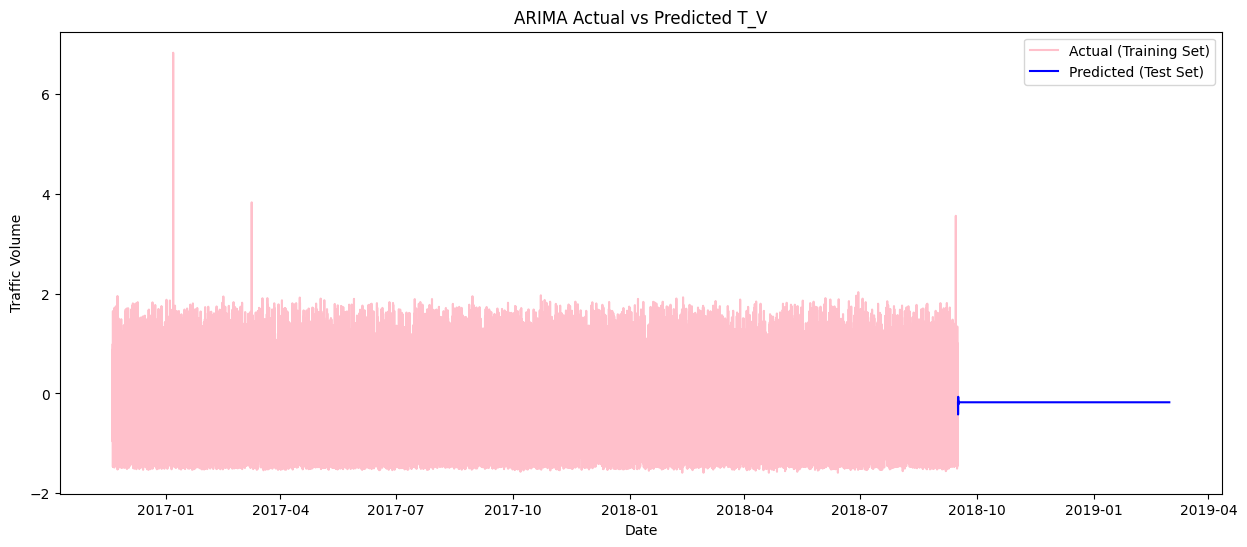

In [156]:
plt.figure(figsize=(15, 6))
plt.plot(arima_train, color='pink', label="Actual (Training Set)")
plt.plot(arima_test.index, arima_predictions, color='blue', label="Predicted (Test Set)")

plt.title("ARIMA Actual vs Predicted T_V")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [119]:
# Model2#LSTM
lstm_train = train_data[['traffic_volume', 'lag_1', 'lag_2', 'rolling_mean_24h']].values
lstm_test = test_data[['traffic_volume', 'lag_1', 'lag_2', 'rolling_mean_24h']].values

In [120]:
#Reshape data to  3D forma
lstm_train = lstm_train.reshape((lstm_train.shape[0], 1, lstm_train.shape[1]))
lstm_test = lstm_test.reshape((lstm_test.shape[0], 1, lstm_test.shape[1]))

In [121]:
# Build
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(lstm_train.shape[1], lstm_train.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [122]:
# Train
lstm_model.fit(lstm_train, train_data['traffic_volume'], epochs=10, batch_size=32, verbose=1)

Epoch 1/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.4595
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.7394e-04
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4696e-04
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2550e-04
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6369e-04
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1351e-04
Epoch 7/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7105e-04
Epoch 8/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.6669e-04
Epoch 9/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0439e-04
Epoch 10/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.5568e-05


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [123]:
#predictions
lstm_predictions = lstm_model.predict(lstm_test)
lstm_mse = mean_squared_error(test_data['traffic_volume'], lstm_predictions)
lstm_mae = mean_absolute_error(test_data['traffic_volume'], lstm_predictions)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [135]:
# Store
test_data['lstm_predictions'] = lstm_predictions

<ipython-input-135-51bc47f2fed5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['lstm_predictions'] = lstm_predictions


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [136]:
lstm_mse = mean_squared_error(test_data['traffic_volume'], lstm_predictions)
lstm_mae = mean_absolute_error(test_data['traffic_volume'], lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)

print(f'LSTM Model - MSE: {lstm_mse}, MAE: {lstm_mae}, RMSE: {lstm_rmse}')

LSTM Model - MSE: 6.705159651910988e-05, MAE: 0.00586767501343529, RMSE: 0.008188503924350887


In [142]:
#compare M Performance
print(f"ARIMA Model - MSE: {arima_mse}, MAE: {arima_mae}")
print(f"LSTM Model - MSE: {lstm_mse}, MAE: {lstm_mae}")
print(f"LSTM Model - RMSE: {lstm_rmse}, RMSE: {lstm_rmse}")
print(f"ARIMA Model - RMSE: {arima_rmse}, RMSE: {arima_rmse}")

ARIMA Model - MSE: 1.0261469361493534, MAE: 0.8886626815266528
LSTM Model - MSE: 6.705159651910988e-05, MAE: 0.00586767501343529
LSTM Model - RMSE: 0.008188503924350887, RMSE: 0.008188503924350887
ARIMA Model - RMSE: 1.012989109590697, RMSE: 1.012989109590697


## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

**1- Data Preprocessing**  I handled missing values using forward filling

**2-Feature Engineering**  I created lag features

**3-Model Architecture** the Models ARIMA and LSTM

**4-Training Process**  Bepochs=10, batch_size=32, Adam optimizer